# 2.0 Feature Engineering

We have 81 features in total and we would like to use different models to guide us in the feature selection process.

## 2.2 Feature Importance Experiments

- Feature importance from model coefficients
- Feature importance from decision trees
- Feature importance from model agnostic approaches

### Setup and Data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("data/training-selected/all/pose_data_augmented_z_res_0301.csv")

#keywords = ['handstand','butterfly']
#filtered_data = data[data['label'].str.contains('|'.join(keywords), na=False)]
#data = filtered_data

p_labels = data['label_encoded'].values
d_labels = data['difficulty'].values

features = pd.concat([data.iloc[:, 6:9], data.iloc[:, 39:93], data.iloc[:, 105:]], axis=1)
feature_names = features.columns

importances = pd.DataFrame(index=feature_names)

scaler = StandardScaler()
X = scaler.fit_transform(features)
y = p_labels

## 2.2.1 Model Coefficients

### Logistic Regression Feature Importance

Weights from logistic regression coefficients help highlight key features by changing distances in the feature space, with larger coefficients indicating greater influence on a query point's class. Negative coefficients mean a feature has an opposite effect on the outcome compared to features with positive coefficients.

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


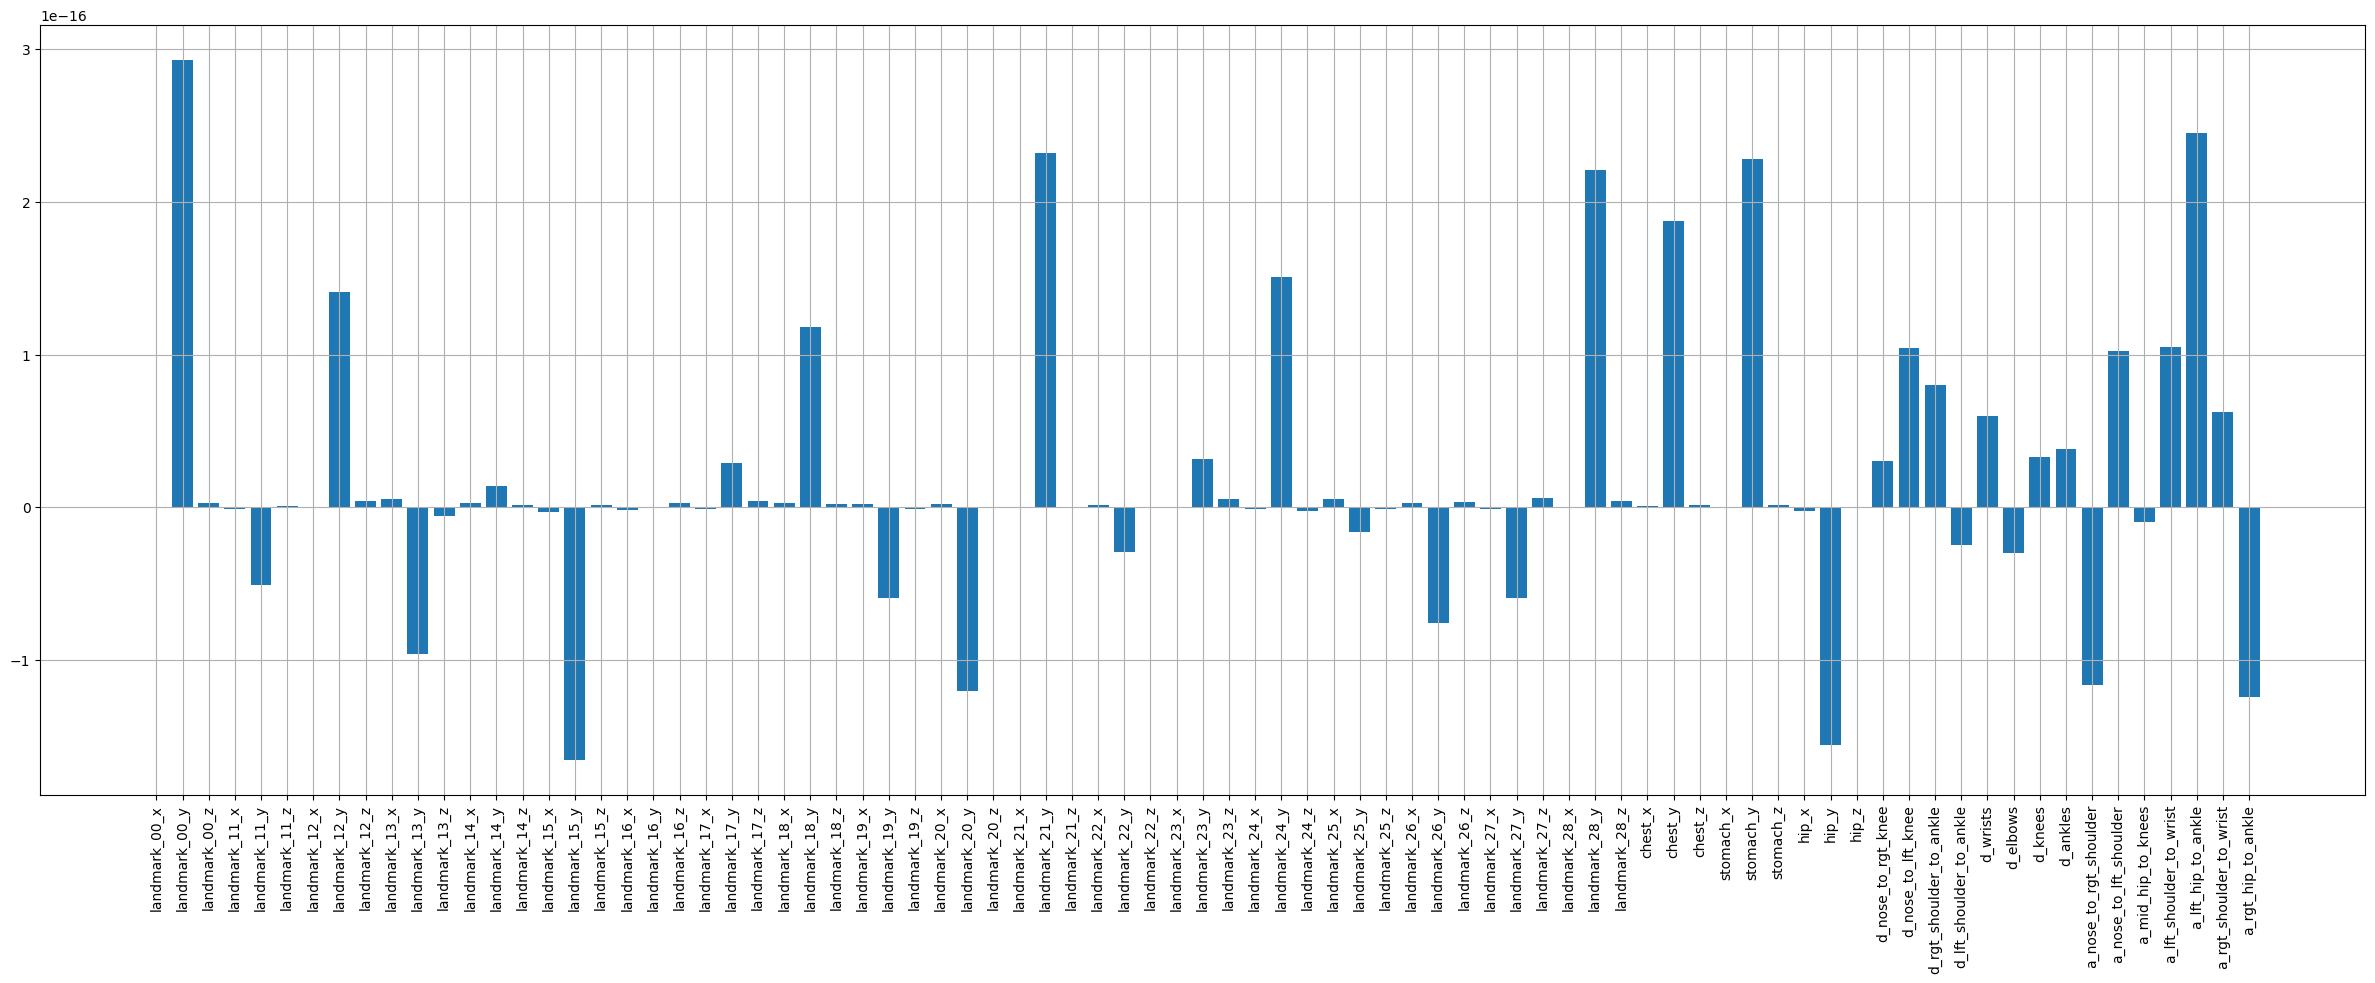

In [18]:
from sklearn.linear_model import LogisticRegression

logr_model = LogisticRegression(max_iter=5)
logr_model.fit(X, y)

importances['logr'] = np.mean(logr_model.coef_, axis=0)

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(feature_names, importances['logr'])
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True) 
plt.show()

## 2.2.2 Decision Trees

### Gini Impurity 

In Decision Trees using Gini impurity, weights with higher values show a greater contribution to reducing uncertainty in classifying data by effectively splitting the dataset into purer nodes.

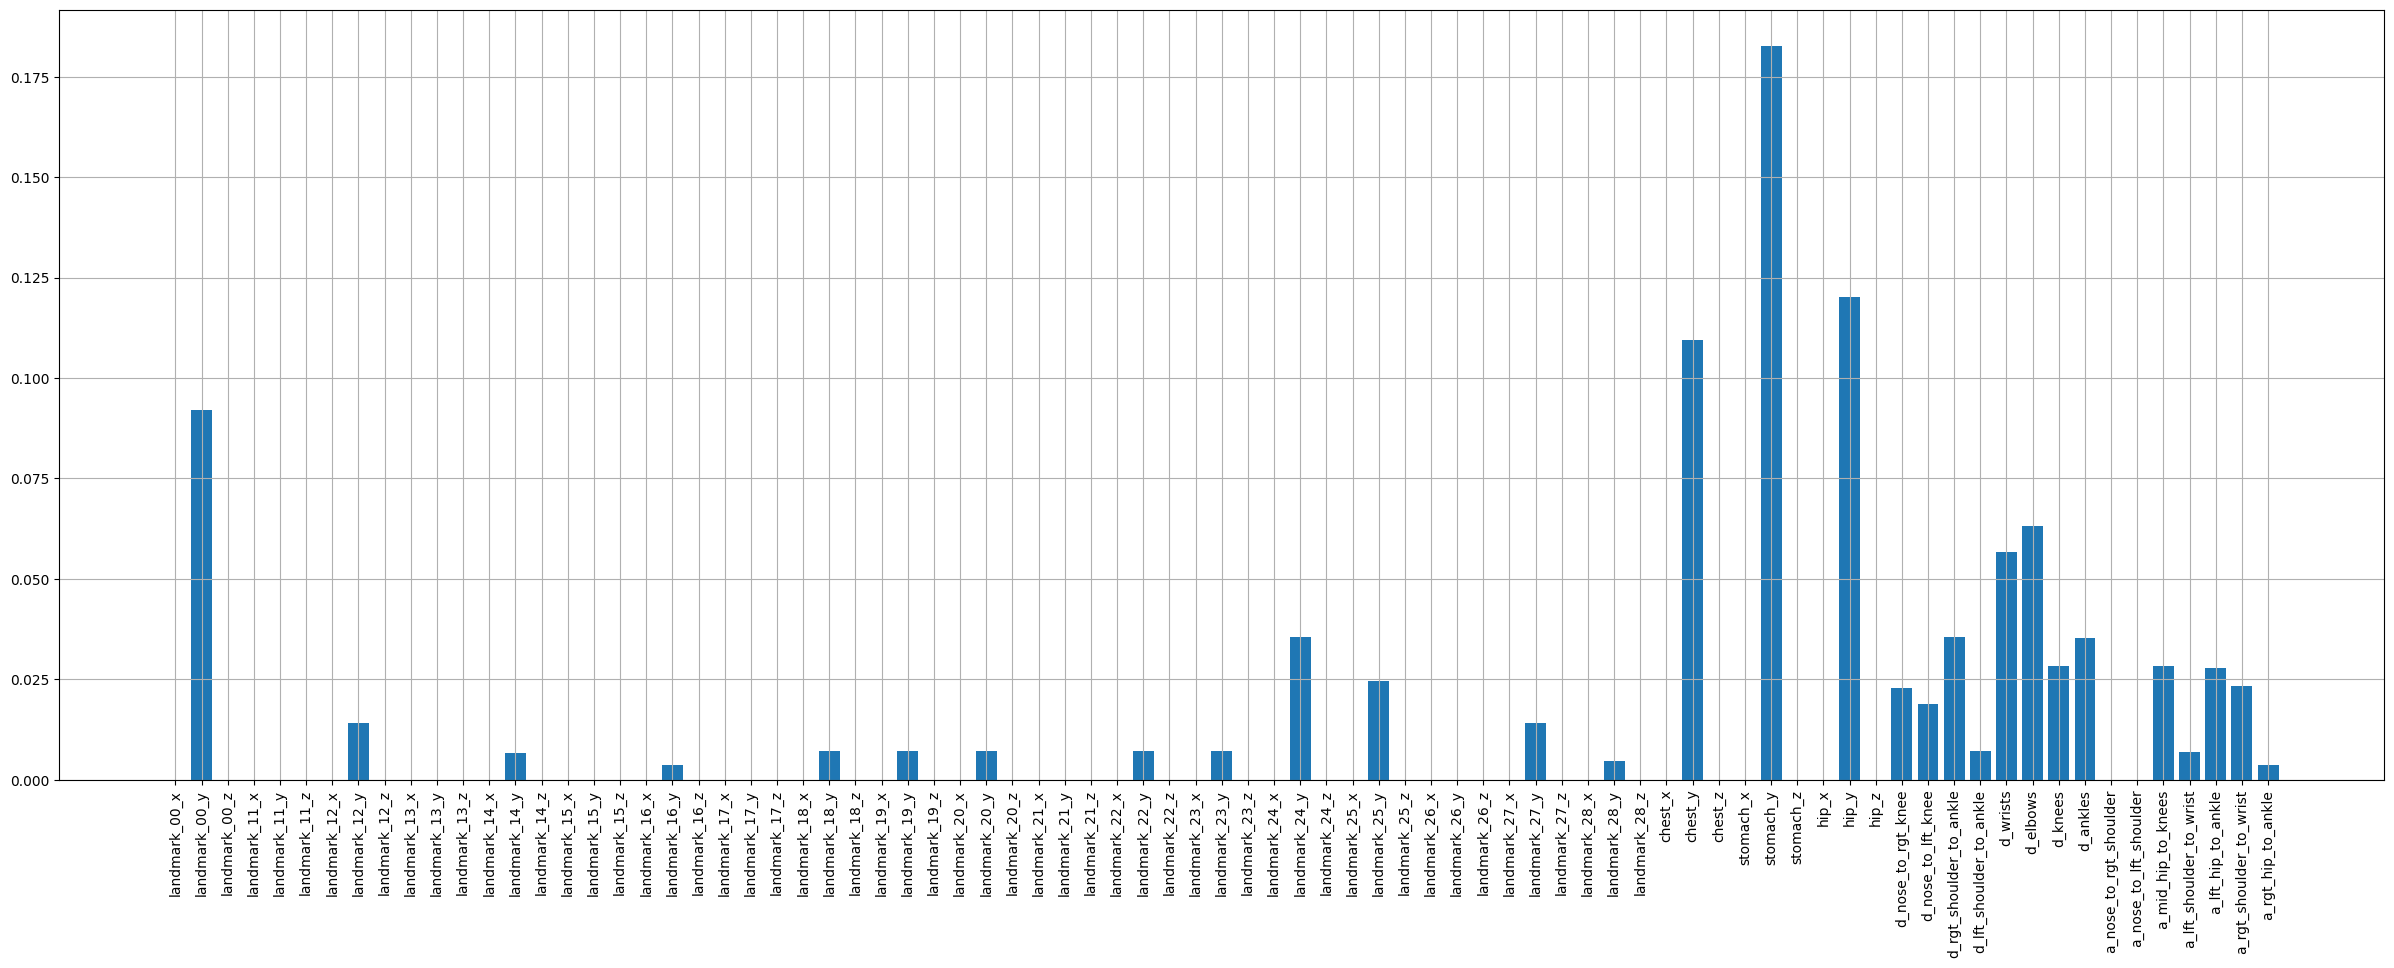

In [22]:
from sklearn.tree import DecisionTreeClassifier

gini_model = DecisionTreeClassifier(criterion='gini')
gini_model.fit(X, y)

importances['gini'] = gini_model.feature_importances_

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(feature_names, importances['gini'])
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True) 
plt.show()

## 2.2.3 Model Agnostic Approaches

**Permutation Testing**: Weights derived from permutation feature importance represent how much the model's prediction accuracy relies on each feature. The more the accuracy decreases when a feature's values are shuffled, the more important that feature is deemed to be.

/var/folders/8q/psx_9spx6sn4p06701_g30nh0000gn/T/ipykernel_35639/4213566575.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(feature_names, rotation=90)


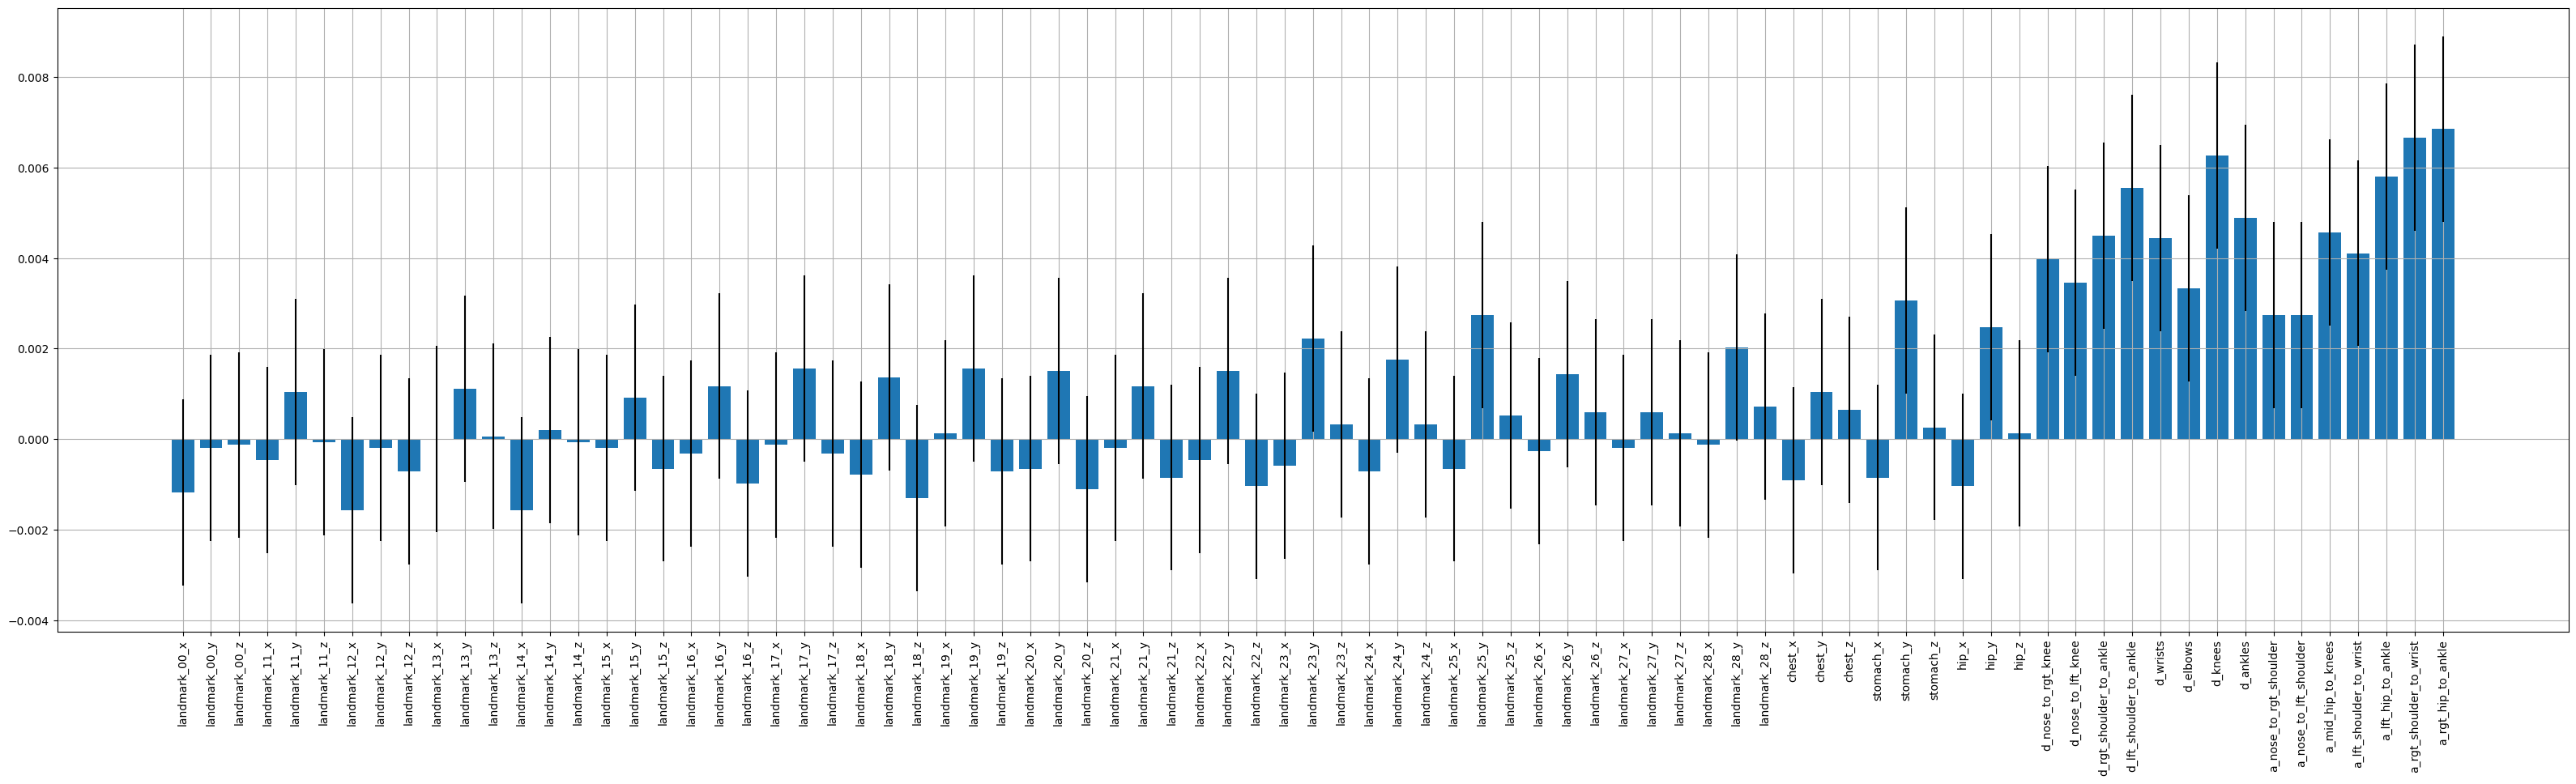

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

knn = KNeighborsClassifier()
Xs, _, ys, _ = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)
knn.fit(Xs, ys)
results = permutation_importance(knn, Xs, ys, scoring='accuracy', n_repeats=3, n_jobs=1)
importances['permutation'] = results.importances_mean

importances_std = np.std(importances['permutation'], axis=0)

fig, ax = plt.subplots(figsize=(40, 10))
ax.bar(feature_names, importances['permutation'], yerr=importances_std, align='center')
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True)
plt.show()

**SHAP Model**

PermutationExplainer explainer: 2046it [08:19,  4.04it/s]         


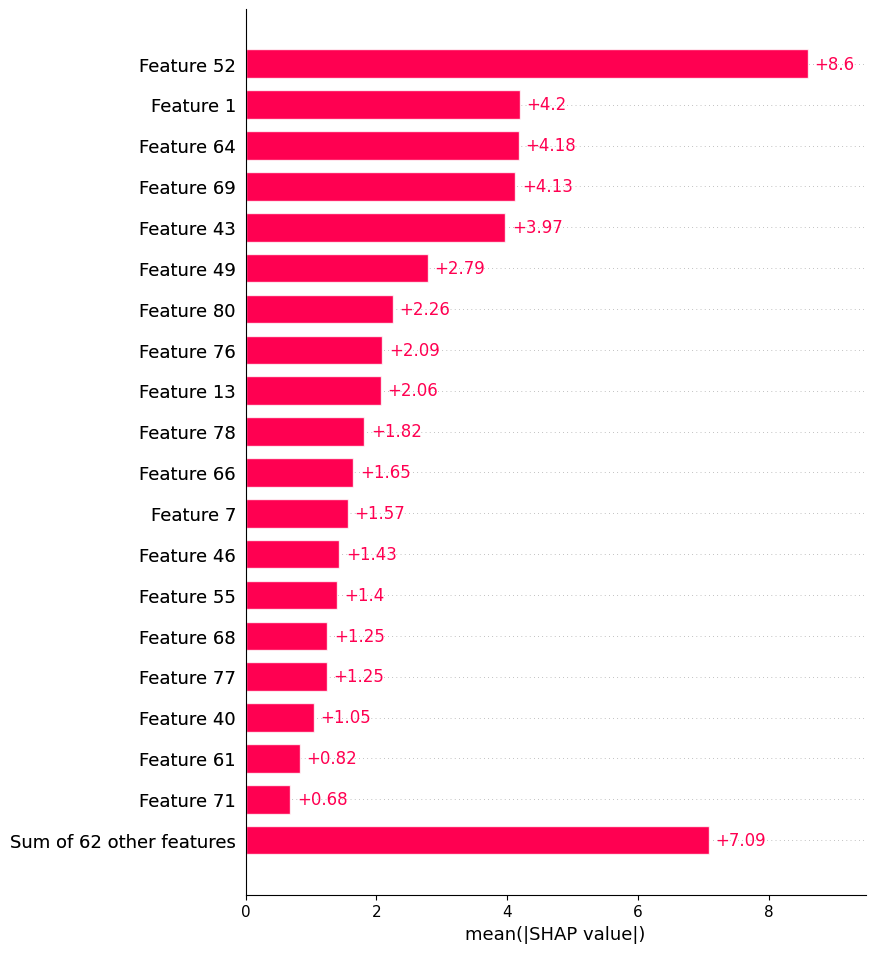

In [14]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = RandomForestRegressor()
model.fit(X_train, y_train)

explainer = shap.Explainer(model.predict, X_test)
shap_values1 = explainer(X_test)

shap.plots.bar(shap_values1, max_display=20)

In [27]:
feature_importances = np.abs(shap_values1.values).mean(axis=0)
feature_weights = feature_importances / np.sum(feature_importances)

importances['shap'] = feature_weights

## Compile Results

In [28]:
importances

,logr,gini,permutation,shap
landmark_00_x,-3.886141e-19,0.000000,-0.001174,0.000000
landmark_00_y,2.933036e-16,0.092008,-0.000196,0.077332
landmark_00_z,2.712101e-18,0.000000,-0.000130,0.000000
landmark_11_x,-1.351858e-18,0.000000,-0.000456,0.000000
landmark_11_y,-5.118049e-17,0.000000,0.001043,0.006198
...,...,...,...,...
a_mid_hip_to_knees,-9.448707e-18,0.028235,0.004564,0.038485
a_lft_shoulder_to_wrist,1.047232e-16,0.006890,0.004108,0.022947
a_lft_hip_to_ankle,2.448790e-16,0.027751,0.005803,0.033465
a_rgt_shoulder_to_wrist,6.259768e-17,0.023357,0.006651,0.006836


In [30]:
importances.to_csv("feature_weights_20240311.csv", index=False)

### Results

Across various feature importance metrics employed, a consistent pattern emerged: y-variables as predominantly influential in model predictions. This regularity suggests that the vertical dimensions of the images hold key discriminative information. Given that the dataset comprises images with a uniform aspect ratio and captured under similar conditions, it is reasonable to extrapolate that future datasets obtained in a like manner would exhibit a comparable hierarchy of feature importance. This underlines the significance of standardized image acquisition in ensuring the replicability of the model's interpretive patterns.

# Resources

1. https://machinelearningmastery.com/calculate-feature-importance-with-python/
2. https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/